Epoch [1/100]
  Train Loss: 1.2495, Train Acc: 46.25%
  Val   Loss: 1.4887, Val   Acc: 27.50%
✅ Checkpoint saved at epoch 1 with val_acc: 27.50%
Epoch [2/100]
  Train Loss: 1.0715, Train Acc: 57.75%
  Val   Loss: 1.2714, Val   Acc: 45.00%
✅ Checkpoint saved at epoch 2 with val_acc: 45.00%
Epoch [3/100]
  Train Loss: 1.0044, Train Acc: 61.00%
  Val   Loss: 1.1502, Val   Acc: 60.00%
✅ Checkpoint saved at epoch 3 with val_acc: 60.00%
Epoch [4/100]
  Train Loss: 0.9156, Train Acc: 66.00%
  Val   Loss: 1.1196, Val   Acc: 62.50%
✅ Checkpoint saved at epoch 4 with val_acc: 62.50%
Epoch [5/100]
  Train Loss: 0.8372, Train Acc: 69.00%
  Val   Loss: 1.1777, Val   Acc: 50.00%
Epoch [6/100]
  Train Loss: 0.7823, Train Acc: 70.25%
  Val   Loss: 1.0198, Val   Acc: 60.00%
Epoch [7/100]
  Train Loss: 0.7639, Train Acc: 73.25%
  Val   Loss: 1.0646, Val   Acc: 62.50%
Epoch [8/100]
  Train Loss: 0.6712, Train Acc: 76.62%
  Val   Loss: 1.1013, Val   Acc: 60.00%
Epoch [9/100]
  Train Loss: 0.6063, Train Ac

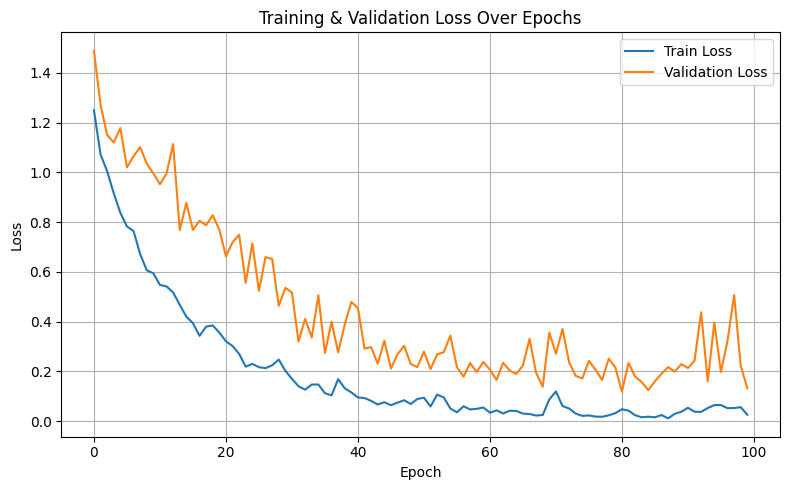


Loading best model for final validation...


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_8708\1057515113.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path)['model_

Final Test Accuracy of Best Model: 97.50%
Final Test Loss of Best Model: 0.1653


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

# CBAM - Channel Attention
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

# CBAM - Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out) * x

# CBAM Block (Channel + Spatial Attention)
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

# Define Face Recognition Model
class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionModel, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            
            CBAM(128),  # Using traditional CBAM
            
            nn.AdaptiveAvgPool2d(1)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
# Model Checkpoint Class
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_acc', save_best_only=True, mode='max'):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = float('-inf') if mode == 'max' else float('inf')

    def __call__(self, current, epoch, model, optimizer):
        is_better = (current > self.best) if self.mode == 'max' else (current < self.best)
        if self.save_best_only and not is_better:
            return
        self.best = current
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            self.monitor: current
        }
        torch.save(checkpoint, self.filepath)
        print(f"✅ Checkpoint saved at epoch {epoch + 1} with {self.monitor}: {current:.2f}%")

# Load Data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = r'D:\Projects\Sentinel turret rover\Data\4Class_Data_split'
train_dataset = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Function
def evaluate(model, loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    avg_loss = total_loss / len(loader)
    return acc, avg_loss


# Validation Function
def validate_model(model, test_loader, device, criterion):
    test_acc, test_loss = evaluate(model, test_loader, device, criterion)
    print(f"Final Test Accuracy of Best Model: {test_acc:.2f}%")
    print(f"Final Test Loss of Best Model: {test_loss:.4f}")


# Training Function with Checkpoint
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001,
                save_path=r'D:\Projects\Sentinel turret rover\model\CA_CBAM.pth'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_acc', save_best_only=True, mode='max')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_acc, val_loss = evaluate(model, test_loader, device, criterion)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

        checkpoint(val_acc, epoch, model, optimizer)

    # Plot Training & Validation Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training & Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Load best model
    print("\nLoading best model for final validation...")
    model.load_state_dict(torch.load(save_path)['model_state_dict'])
    validate_model(model, test_loader, device, criterion)


# Main Execution 
if __name__ == "__main__":
    model = FaceRecognitionModel(num_classes=len(train_dataset.classes))
    train_model(model, train_loader, test_loader, num_epochs=100, lr=0.001)

In [4]:
from torchsummary import summary

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceRecognitionModel(num_classes=len(train_dataset.classes)).to(device)

# Print summary (assuming input image size is 3 x 128 x 128)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,